<a href="https://colab.research.google.com/github/jiin124/Kaggle/blob/main/Heart_Attack_Analysis_%26_Prediction_Dataset/Heart_Attack_Analysis_%26_Prediction_Dataset_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/ruslansikhamov/heart-attack-eda-prediction-catboost-0-92-roc-auc


age - age in years

sex - sex (0 = female; 1 = male)

cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 0 = asymptomatic)

trtbps - resting blood pressure (in mm Hg on admission to the hospital)

chol - serum cholestoral in mg/dl

fbs - fasting blood sugar > 120 mg/dl (0 = false; 1 = true)

restecg - resting electrocardiographic results (0 = normal; 1 = hypertrophy; 2 = having ST-T wave abnormality)

thalachh - maximum heart rate achieved

exng - exercise induced angina (0 = no; 1 = yes)

oldpeak - ST depression induced by exercise relative to rest

slp - the slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)

caa - number of major vessels (0-4) colored by flourosopy

thall - thallium stress test (1 = fixed defect; 2 = reversable defect; 3 = normal)

output - 0 = less chance of heart attack; 1 = more chance of heart attack

In [ ]:
pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.linear_model import LogisticRegression

from scipy.stats import uniform
from scipy.stats import loguniform

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from catboost import CatBoostClassifier

In [ ]:
os.environ['KAGGLE_USERNAME']='jiinpp'
os.environ['KAGGLE_KEY']="b06d525a9f66198051ccb648b091778a"

In [ ]:
!kaggle datasets download -d rashikrahmanpritom/heart-attack-analysis-prediction-dataset

  0% 0.00/4.11k [00:00<?, ?B/s]
100% 4.11k/4.11k [00:00<00:00, 3.27MB/s]


In [ ]:
!unzip '*.zip'

Archive:  heart-attack-analysis-prediction-dataset.zip
  inflating: heart.csv               
  inflating: o2Saturation.csv        


In [ ]:
df=pd.read_csv('heart.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


데이터 세트에는 303명의 환자에 대한 정보가 포함됩니다.
13가지 기능이 있습니다. 그 중 12개는 정수형이지만 실제로는 6개만 숫자형이고 나머지는 범주형입니다.
대상이 출력됩니다. 0은 저위험 환자, 1은 고위험 환자입니다.
누락된 값이 없습니다.

## EDA

### Numerical variables

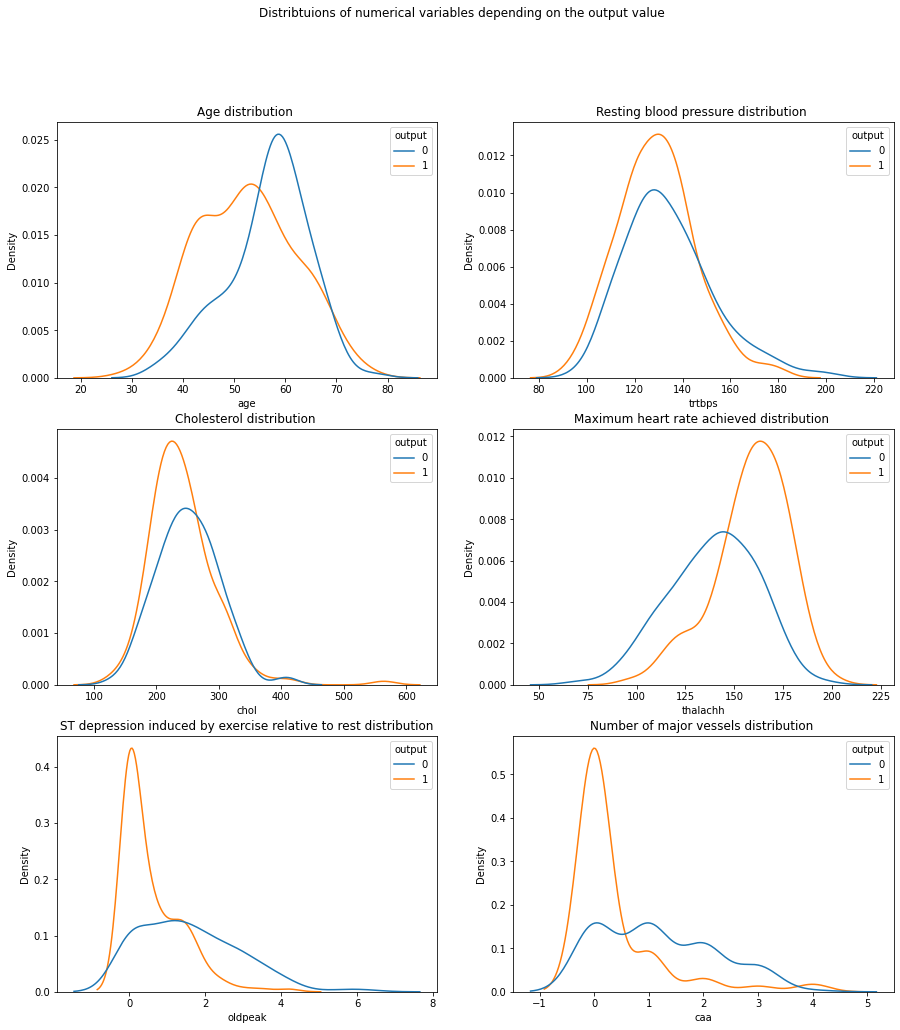

In [ ]:
_, axes = plt.subplots(3, 2, figsize=(15,16))
sns.kdeplot(data=df, x='age', hue='output', ax=axes[0, 0])
axes[0, 0].set_title('Age distribution ')
sns.kdeplot(data=df, x='trtbps', hue='output', ax=axes[0, 1])
axes[0, 1].set_title('Resting blood pressure distribution ')
sns.kdeplot(data=df, x='chol', hue='output', ax=axes[1, 0])
axes[1, 0].set_title('Cholesterol distribution ')
sns.kdeplot(data=df, x='thalachh', hue='output', ax=axes[1, 1])
axes[1, 1].set_title('Maximum heart rate achieved distribution ')  
sns.kdeplot(data=df, x='oldpeak', hue='output', ax=axes[2, 0])
axes[2, 0].set_title('ST depression induced by exercise relative to rest distribution')
sns.kdeplot(data=df, x='caa', hue='output', ax=axes[2, 1])
axes[2, 1].set_title('Number of major vessels distribution ')
plt.suptitle('Distribtuions of numerical variables depending on the output value')
plt.show()

### Categorical variables

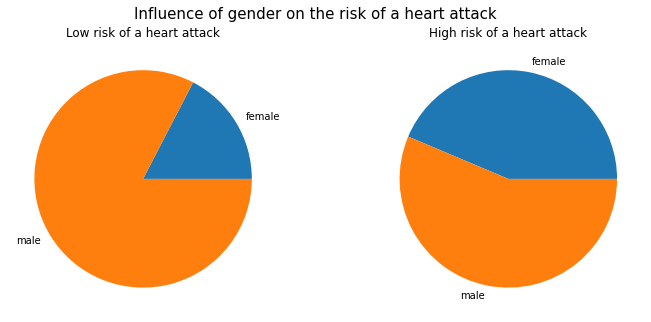

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].pie(df.query('output == 0').groupby('sex')['sex'].count(), labels=['female', 'male'])
axes[0].set_title('Low risk of a heart attack')
axes[1].pie(df.query('output == 1').groupby('sex')['sex'].count(), labels=['female', 'male'])
axes[1].set_title('High risk of a heart attack')
plt.suptitle('Influence of gender on the risk of a heart attack', fontsize=15)
plt.show()

In [ ]:
df.groupby('output',as_index=False)['sex'].mean()

,output,sex
0,0,0.826087
1,1,0.563636


저위험군에서는 남성이 82.6%, 고위험군에서는 남성이 56.4%로 낮은 편이다. 그것으로부터 우리는 여성보다 심장병에 걸리기 쉽다는 결론을 내릴 수 있습니다.

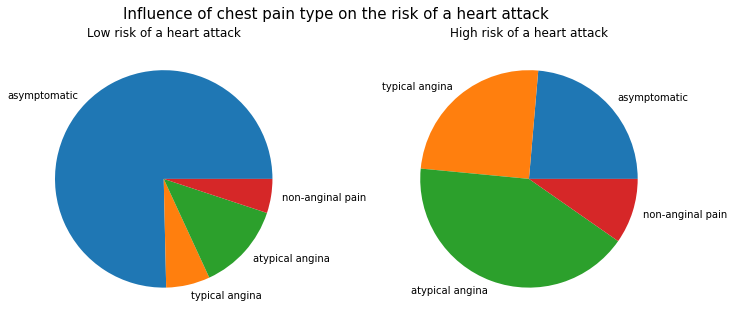

In [ ]:
_, axes=plt.subplots(1,2,figsize=(12,5))

labels= ['asymptomatic', 'typical angina', 'atypical angina', 'non-anginal pain']

axes[0].pie(df.query('output==0').groupby('cp')['cp'].count(),labels=labels)
axes[0].set_title('Low risk of a heart attack')

axes[1].pie(df.query('output == 1').groupby('cp')['cp'].count(), labels=labels)
axes[1].set_title('High risk of a heart attack')

plt.suptitle('Influence of chest pain type on the risk of a heart attack', fontsize=15)
plt.show()

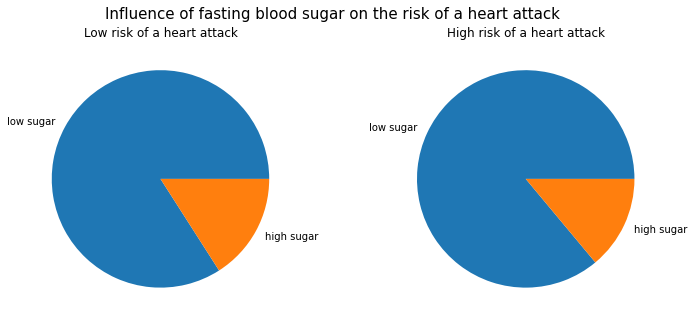

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(12,5))
labels = ['low sugar', 'high sugar']

axes[0].pie(df.query('output == 0').groupby('fbs')['fbs'].count(), labels=labels)
axes[0].set_title('Low risk of a heart attack')
axes[1].pie(df.query('output == 1').groupby('fbs')['fbs'].count(), labels=labels)
axes[1].set_title('High risk of a heart attack')
plt.suptitle('Influence of fasting blood sugar on the risk of a heart attack', fontsize=15)
plt.show()


공복 혈당은 산출량에 영향을 미치지 않습니다.

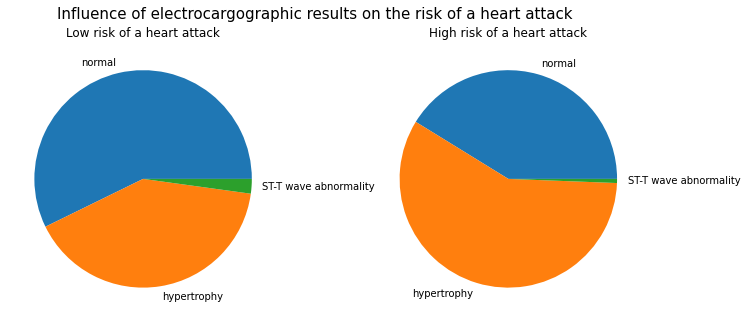

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(12,5)) 

labels = ['normal', 'hypertrophy', 'ST-T wave abnormality']

axes[0].pie(df.query('output == 0').groupby('restecg')['restecg'].count(), labels=labels)
axes[0].set_title('Low risk of a heart attack')
axes[1].pie(df.query('output == 1').groupby('restecg')['restecg'].count(), labels=labels)
axes[1].set_title('High risk of a heart attack')
plt.suptitle('Influence of electrocargographic results on the risk of a heart attack', fontsize=15)
plt.show()


비대가 있는 사람들은 심장마비에 걸리기 쉽습니다.

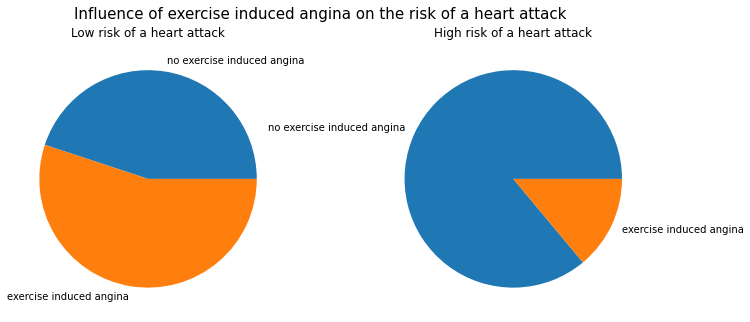

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(12,5))
labels = ['no exercise induced angina', 'exercise induced angina']

axes[0].pie(df.query('output == 0').groupby('exng')['exng'].count(), labels=labels)
axes[0].set_title('Low risk of a heart attack')
axes[1].pie(df.query('output == 1').groupby('exng')['exng'].count(), labels=labels)
axes[1].set_title('High risk of a heart attack')
plt.suptitle('Influence of exercise induced angina on the risk of a heart attack', fontsize=15)
plt.show()

고위험군에는 운동 유발 협심증이 있는 사람이 훨씬 적습니다.

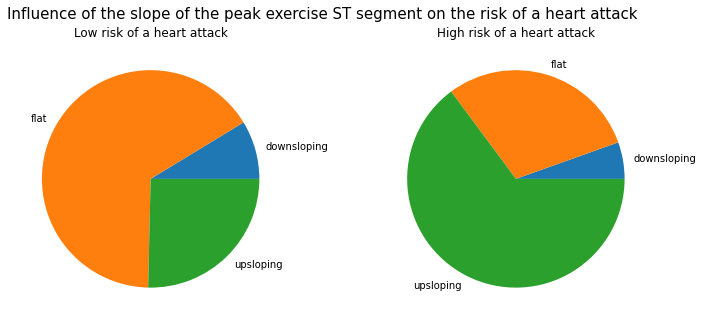

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(12,5))
labels = ['downsloping', 'flat', 'upsloping']

axes[0].pie(df.query('output == 0').groupby('slp')['slp'].count(), labels=labels)
axes[0].set_title('Low risk of a heart attack')
axes[1].pie(df.query('output == 1').groupby('slp')['slp'].count(), labels=labels)
axes[1].set_title('High risk of a heart attack')
plt.suptitle('Influence of the slope of the peak exercise ST segment on the risk of a heart attack', fontsize=15)
plt.show()


양의 기울기를 가진 사람들은 심장마비의 가능성이 더 높습니다.

In [ ]:
df.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

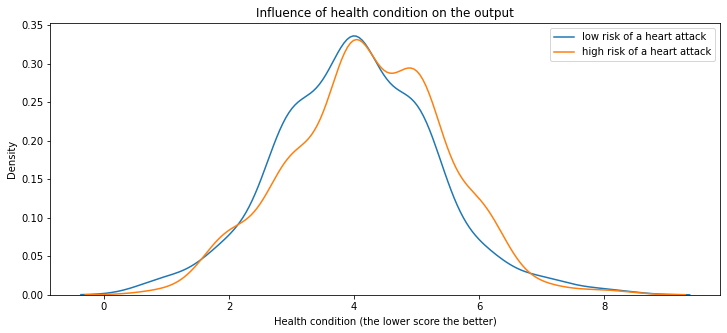

In [ ]:
plt.figure(figsize=(12,5))
df_0 = df.query('output == 0')
df_1 = df.query('output == 1')
sns.kdeplot(df_0.cp + df_0.restecg + df_0.exng + df_0.thall, label='low risk of a heart attack')
sns.kdeplot(df_1.cp + df_1.restecg + df_1.exng + df_1.thall, label='high risk of a heart attack')
plt.title('Influence of health condition on the output')
plt.xlabel('Health condition (the lower score the better)')
plt.legend()
plt.show()


결론은 건강 상태가 좋은 사람들이 심장마비에 걸릴 확률이 낮다는 것입니다.

Conclusions
The majority of the patients are older than 40.

In the dataset there are 2 times more males than females.

54.5% of the patients have a high risk of heart attack, 45.5% - low risk of a heart attack. The classes are relatively balanced.

The following numerical features affect the output: age, maximum heart rate achieved, ST depression induced by exercise relative to rest distribution, and the number of major vessels.

All categorical features, except fasting blood sugar, affect the output.

Age distribution of patients from the high-risk group has a peak at 50-52 ages.

Women are more prone to a heart attack than men.

Patients that have normal analysis results (such as electrocardiography or thallium stress test) are less likely to have a heart attack.

## feature engineering


In [ ]:
df_new=df.copy()

### removing the features

불필요한 기능을 제거하는 것부터 시작하겠습니다. 이전 섹션에서 우리는 혈압, 콜레스테롤 및 혈당이 심장마비에 영향을 미치지 않는다고 가정합니다. 확인하기 위해 RandomForestClassifier의 속성 featureimportnaces를 사용합니다.

In [ ]:
rf_classifier=RandomForestClassifier(max_depth=8,
                                     n_estimators=100,
                                     random_state=42)

rf_classifier.fit(df.drop('output',axis=1),df['output'])

RandomForestClassifier(max_depth=8, random_state=42)

In [ ]:
#랜덤포레스트 피쳐중요도 
importance=pd.concat([pd.Series(df.columns[:-1]),
                      pd.Series(rf_classifier.feature_importances_)],axis=1)

importance.columns=['feature','importance']
importance=importance.sort_values(by='importance',ascending=False)
importance

,feature,importance
2,cp,0.140840
7,thalachh,0.128442
12,thall,0.112759
11,caa,0.110391
9,oldpeak,0.104669
0,age,0.083871
3,trtbps,0.075149
4,chol,0.071897
8,exng,0.059953
10,slp,0.052096


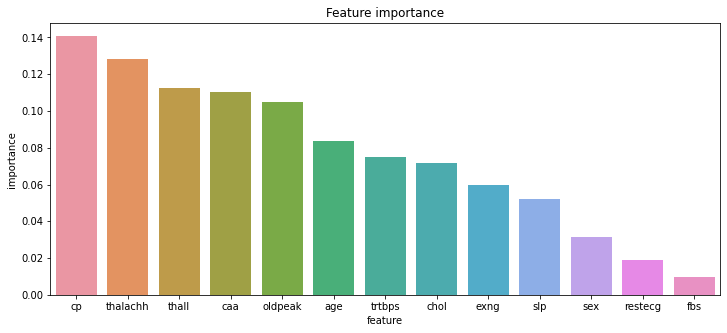

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(data=importance,x='feature',y='importance')
plt.title('Feature importance')
plt.show()

공복혈당 제거하기

In [ ]:
df_new=df_new.drop('fbs',axis=1)

## Adding new features

출력에 영향을 미치는 기능은 달성된 최대 심박수이다. 의료 실습에서는 다음 방정식을 사용해 계산된다. 

MHR=208−(0.7×age)

In [ ]:
df_new['mhr_estimation']=208-0.7*df_new['age']

혈압에서 새로운 범주형 특성을 만들 수 있습니다. 
- pressure < 120 = 0(정상)
- 120 <= pressure < 140 = 1(상승)
- 140 <= pressure = 2(높음)

In [ ]:
df_new['blood_pres_cat']=df_new['trtbps'].apply(lambda x:0 if x<120 else (1 if x<140 else 2))

In [ ]:
df_new['blood_pres_cat'].value_counts().to_frame()

,blood_pres_cat
1,146
2,97
0,60


the same idea can be applied to the cholesterol level

- cholesterol < 200 = 0 (desirable)
- 200 <= cholesterol < 240 = 1 (borderline)
- 240 <= cholesterol = 2 (high)


In [ ]:
df_new['cholesterol_cat']=df_new['chol'].apply(lambda x:0 if x<200 else (1 if x<240 else 2))

In [ ]:
df_new['cholesterol_cat'].value_counts()

2    155
1     98
0     50
Name: cholesterol_cat, dtype: int64

위에서 만든 새로운 피처에 대한 기능을 만들 수 있다. 간단히 두 가지 범주를 요약해보겠다. 사람이 0이면 혈압과 콜레스테롤이 정상임을 의미한다. 값이 4이면 고혈압과 고콜레스테로링 있음을 의미한다. 

In [ ]:
df_new['pres_chol_sum_cat']=df_new['blood_pres_cat']+df_new['cholesterol_cat']

In [ ]:
df_new['pres_chol_sum_cat'].value_counts().to_frame()

,pres_chol_sum_cat
3,109
2,84
4,52
1,45
0,13


값이 낮을수록 건강이 더 좋다고 말할 수 있따. 

In [ ]:
df_new['cat_sum']=df_new['cp']+df_new['restecg']+df_new['exng']+df_new['thall']

In [ ]:
df_new['cat_sum'].value_counts().to_frame()

,cat_sum
4,101
5,81
3,61
6,27
2,22
7,5
1,4
8,2


In [ ]:
df_new.head()

,age,sex,cp,trtbps,chol,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,mhr_estimation,blood_pres_cat,cholesterol_cat,pres_chol_sum_cat,cat_sum
0,63,1,3,145,233,0,150,0,2.3,0,0,1,1,163.9,2,1,3,4
1,37,1,2,130,250,1,187,0,3.5,0,0,2,1,182.1,1,2,3,5
2,41,0,1,130,204,0,172,0,1.4,2,0,2,1,179.3,1,1,2,3
3,56,1,1,120,236,1,178,0,0.8,2,0,2,1,168.8,1,1,2,4
4,57,0,0,120,354,1,163,1,0.6,2,0,2,1,168.1,1,2,3,4


## assessment of changes

두 데이터 사이의 성능 평가를 비교해볼 수 있따. 

In [ ]:
cross_val_score(
    estimator=RandomForestClassifier(max_depth=8,
                                     n_estimators=100,
                                     random_state=42),
                
    X=df.drop('output',axis=1),
    y=df['output'],
    scoring='f1',
    cv=5
).mean()

0.8506528472990282

In [ ]:
cross_val_score(
    estimator=RandomForestClassifier(max_depth=8,
                                     n_estimators=100,
                                     random_state=42),
                
    X=df_new.drop('output',axis=1),
    y=df_new['output'],
    scoring='f1',
    cv=5
).mean()

0.829961072815524

성능이 더 떨어졌다..!! 이게 무슨 일


## Data preparation

In [ ]:
num_features = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'caa', 'mhr_estimation']
cat_features = ['sex', 'cp', 'restecg', 'exng', 'slp', 'thall', 'blood_pres_cat', 'cholesterol_cat', 'pres_chol_sum_cat', 'cat_sum']

In [ ]:
features=df_new.drop('output',axis=1)
target=df_new['output'].astype('int')

In [ ]:
print(features.shape)
print(target.shape)

(303, 17)
(303,)


In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                303 non-null    int64  
 1   sex                303 non-null    int64  
 2   cp                 303 non-null    int64  
 3   trtbps             303 non-null    int64  
 4   chol               303 non-null    int64  
 5   restecg            303 non-null    int64  
 6   thalachh           303 non-null    int64  
 7   exng               303 non-null    int64  
 8   oldpeak            303 non-null    float64
 9   slp                303 non-null    int64  
 10  caa                303 non-null    int64  
 11  thall              303 non-null    int64  
 12  mhr_estimation     303 non-null    float64
 13  blood_pres_cat     303 non-null    int64  
 14  cholesterol_cat    303 non-null    int64  
 15  pres_chol_sum_cat  303 non-null    int64  
 16  cat_sum            303 non

## preparagion for catboost

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=42)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(242, 17)
(61, 17)
(242,)
(61,)


In [ ]:
x_train[cat_features] =x_train[cat_features].astype('str')
x_test[cat_features] = x_test[cat_features].astype('str')

## Encoding categorical data

In [ ]:
features_ohe=pd.get_dummies(features,drop_first=True,columns=cat_features)

In [ ]:
features_ohe.head()

,age,trtbps,chol,thalachh,oldpeak,caa,mhr_estimation,sex_1,cp_1,cp_2,...,pres_chol_sum_cat_2,pres_chol_sum_cat_3,pres_chol_sum_cat_4,cat_sum_2,cat_sum_3,cat_sum_4,cat_sum_5,cat_sum_6,cat_sum_7,cat_sum_8
0,63,145,233,150,2.3,0,163.9,1,0,0,...,0,1,0,0,0,1,0,0,0,0
1,37,130,250,187,3.5,0,182.1,1,0,1,...,0,1,0,0,0,0,1,0,0,0
2,41,130,204,172,1.4,0,179.3,0,1,0,...,1,0,0,0,1,0,0,0,0,0
3,56,120,236,178,0.8,0,168.8,1,1,0,...,1,0,0,0,0,1,0,0,0,0
4,57,120,354,163,0.6,0,168.1,0,0,0,...,0,1,0,0,0,1,0,0,0,0


### train_test_split

In [ ]:
features_train,features_test,target_train,target_test=train_test_split(
    features_ohe,
    target,
    test_size=0.2,
    random_state=42
)

In [ ]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(242, 34)
(61, 34)
(242,)
(61,)


### Standardization

In [ ]:
scaler=StandardScaler()
features_train[num_features]=scaler.fit_transform(features_train[num_features])
features_test[num_features]=scaler.transform(features_test[num_features])

In [ ]:
features_train.head()

,age,trtbps,chol,thalachh,oldpeak,caa,mhr_estimation,sex_1,cp_1,cp_2,...,pres_chol_sum_cat_2,pres_chol_sum_cat_3,pres_chol_sum_cat_4,cat_sum_2,cat_sum_3,cat_sum_4,cat_sum_5,cat_sum_6,cat_sum_7,cat_sum_8
132,-1.356798,-0.616856,0.914034,0.532781,-0.920864,-0.689701,1.356798,1,1,0,...,0,1,0,0,0,1,0,0,0,0
202,0.385086,1.169491,0.439527,-1.753582,-0.193787,-0.689701,-0.385086,1,0,0,...,0,0,1,0,0,1,0,0,0,0
196,-0.921327,1.169491,-0.300704,-0.139679,2.350982,-0.689701,0.921327,1,0,1,...,0,1,0,0,0,0,1,0,0,0
75,0.058483,0.276318,0.059921,0.487950,0.351521,-0.689701,-0.058483,0,1,0,...,0,1,0,0,1,0,0,0,0,0
176,0.602822,-0.795490,-0.319684,0.443119,0.351521,1.333421,-0.602822,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
features_test.head()

,age,trtbps,chol,thalachh,oldpeak,caa,mhr_estimation,sex_1,cp_1,cp_2,...,pres_chol_sum_cat_2,pres_chol_sum_cat_3,pres_chol_sum_cat_4,cat_sum_2,cat_sum_3,cat_sum_4,cat_sum_5,cat_sum_6,cat_sum_7,cat_sum_8
179,0.276218,1.169491,0.553408,-1.708752,-0.375556,0.321860,-0.276218,1,0,0,...,0,0,1,1,0,0,0,0,0,0
228,0.493954,2.360389,0.781172,0.398289,-0.739095,-0.689701,-0.493954,1,0,0,...,0,0,1,0,0,0,0,1,0,0
111,0.276218,1.169491,-2.293633,1.025918,-0.739095,0.321860,-0.276218,1,0,1,...,1,0,0,0,0,0,0,1,0,0
246,0.167350,0.216773,3.077785,-0.005187,0.805944,1.333421,-0.167350,0,0,0,...,0,1,0,0,0,1,0,0,0,0
60,1.800367,-1.212304,0.344625,-0.901800,-0.920864,0.321860,-1.800367,0,0,1,...,1,0,0,0,0,1,0,0,0,0


## Modeling

#### SVM

서포트벡터머신

In [ ]:
parameters_svc=dict(
    C=loguniform(0.0001,20),
    kernel=['rbf','poly'],
    gamma=loguniform(0.0001,20)
)

In [ ]:
%%time
random_serach_svc=RandomizedSearchCV(
    estimator=SVC(probability=True,random_state=42),
    param_distrivutions=parameters_svc,
    n_iter=75,
    scoring='f1',
    cv=5,
    random_state=42
)
random_search_svc.fit(features_train,target_train)

TypeError: ignored

오류가 나서 그만두기로 함

### Random Forest

In [ ]:
parameters_rf=dict(
    n_estimators=range(5,1000),
    max_depth=range(4,30),
    min_samples_split=range(2,10),
    min_samples_leaf=range(1,10),
    max_features=range(2,features_train.shape[1])
)

In [ ]:
%%time
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=parameters_rf,
    n_iter=75,
    scoring='f1',
    cv=5,
    random_state=42,
    verbose=1
)
random_search_rf.fit(features_train, target_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
CPU times: user 4min 54s, sys: 1.79 s, total: 4min 56s
Wall time: 4min 57s


In [ ]:
rf_cv_f1=random_search_rf.best_score_
rf_cv_f1

0.8346209262435677

In [ ]:
random_search_rf.best_params_

{'max_depth': 22,
 'max_features': 29,
 'min_samples_leaf': 7,
 'min_samples_split': 5,
 'n_estimators': 751}

In [ ]:
best_rf = random_search_rf.best_estimator_
best_rf


RandomForestClassifier(max_depth=22, max_features=29, min_samples_leaf=7,
                       min_samples_split=5, n_estimators=751, random_state=42)

### catboost

In [ ]:
parameters_boost=dict(
    learning_rate=loguniform(0.0001,0.5),
    iterations=range(10,500),
    depth=range(3,12),
    l2_leaf_reg=uniform(1,20),
    random_strength=loguniform(0.001,1000)
)

In [ ]:
%%time
random_search_boost=RandomizedSearchCV(
    estimator=CatBoostClassifier(verbose=False,cat_features=cat_features,eval_metric='F1'),
    param_distributions=parameters_boost,
    n_iter=25,
    scoring='f1',
    cv=5,
    random_state=42,
    verbose=1
)
random_search_boost.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
CPU times: user 8min 53s, sys: 1min 42s, total: 10min 36s
Wall time: 5min 44s


In [ ]:
random_search_boost.best_params_

{'depth': 9,
 'iterations': 50,
 'l2_leaf_reg': 19.299193510875615,
 'learning_rate': 0.13940142131179573,
 'random_strength': 0.4973980116331517}

In [ ]:
catboost_cv_f1=random_search_boost.best_score_
catboost_cv_f1

0.8533515026409593

In [ ]:
best_catboost = random_search_boost.best_estimator_
best_catboost